# Проект: классификация

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import optuna

**Данные о клиентах банка**:
- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании**:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**Прочие признаки**:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

Целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке 

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
display(df.info())

print('Пропущено значений в признаке balance:', df['balance'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

Пропущено значений в признаке balance: 25


### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ', '').replace('$', '').replace(',', '.')).astype('float')

display(df.head())
print('Средний баланс:', round(df['balance'].mean(), 3))

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Средний баланс: 1529.129


### Задание 4

In [6]:
# обработайте пропуски в признаки balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

print('Пропущено значений в признаке balance:', df['balance'].isnull().sum())
print('Средний баланс:', round(df['balance'].mean(), 3))

Пропущено значений в признаке balance: 0
Средний баланс: 1526.936


### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
columns_to_replace = ['job', 'education']
for col in columns_to_replace:
    df[col] = df[col].replace('unknown', df[col].mode()[0])

In [8]:
mask = (df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0]) 

print(round(df[mask]['balance'].mean(), 3))    

1598.883


### Задание 6

In [9]:
# удалите все выбросы для признака balance
# определяем 25 и 75 квартили 
quartile_1 = df['balance'].quantile(0.25)
quartile_3 =  df['balance'].quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
print('Нижняя граница:', int(lower_bound))
print('Верхняя граница', int(upper_bound))

# исключаем выбросы
mask = (df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)
df = df[mask]
print('Количество записей', df.shape[0])

Нижняя граница: -2241
Верхняя граница 4063
Количество записей 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [10]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

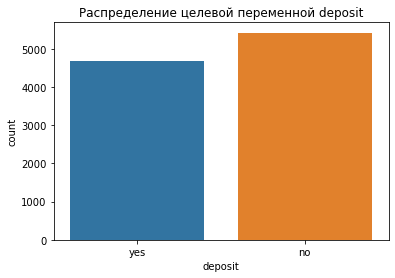

In [11]:
countplot = sns.countplot(df['deposit'])
countplot.set_title('Распределение целевой переменной deposit');

### Задание 2

In [12]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задание 3

In [13]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


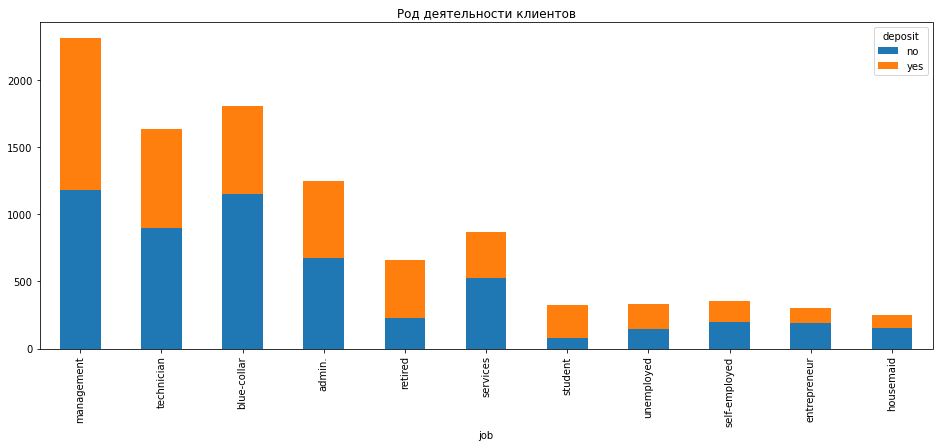

In [14]:
#постройте визуализации, иллюстрирующие результаты
df_plot = (
    df[['job', 'deposit']]
    .pivot_table(columns='deposit', index='job', aggfunc='size')
    .sort_values('yes', ascending=False)
)

df_plot.plot(
    kind='bar', 
    figsize=(16, 6),
    title='Род деятельности клиентов',
    stacked=True
);

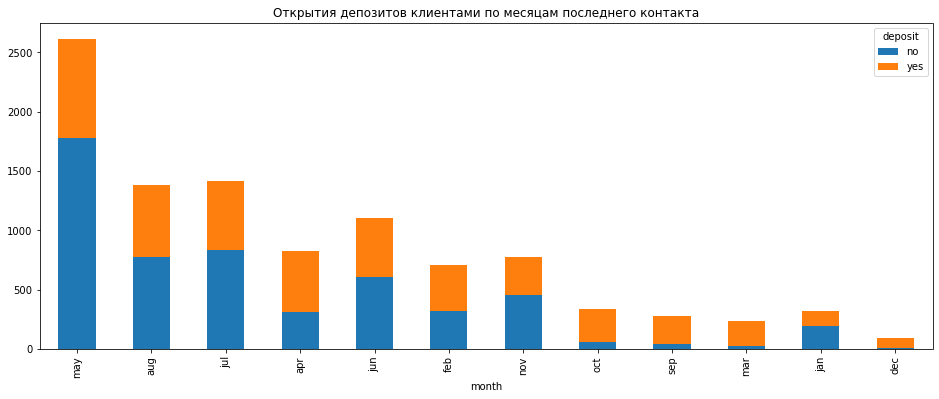

In [15]:
#постройте визуализации, иллюстрирующие результаты
df_plot = (
    df[['month', 'deposit']]
    .pivot_table(columns='deposit', index='month', aggfunc='size')
    .sort_values('yes', ascending=False)
)

df_plot.plot(
    kind='bar', 
    figsize=(16, 6),
    title='Открытия депозитов клиентами по месяцам последнего контакта',
    stacked=True
);

### Задание 4

In [16]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df_plot = (
    df[['poutcome', 'deposit']]
    .pivot_table(columns='deposit', index='poutcome', aggfunc='size')
)

df_plot

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 5

In [17]:
# узнайте, cколько было месяцев, в которых проводилась маркетинговая кампания
mask = df['campaign'] > 0
len(df[mask]['month'].unique())

12

### Задание 7

In [18]:
# Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. 
df_group = df[['month', 'deposit']].groupby('month').value_counts(normalize=True).round(4) * 100

df_group = df_group.reset_index()
df_group.columns = ['month', 'deposit', 'clients, %']
df_group[df_group['deposit'] == 'no'][['month', 'clients, %']].sort_values('clients, %', ascending=False)

,month,"clients, %"
16,may,67.86
8,jan,60.82
10,jul,58.96
18,nov,58.46
2,aug,55.96
12,jun,54.89
7,feb,45.56
1,apr,38.19
21,oct,18.51
23,sep,16.55


In [19]:
def age_to_range(age):
    if age < 30:
        return '<30'
    elif age < 40:
        return '30-40'
    elif age < 50:
        return '40-50'
    elif age < 60:
        return '50-60'
    else:
        return '60+'

In [20]:
df['age_range'] = df['age'].apply(age_to_range)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_range
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


### Задание 8

In [21]:
# Выберите из списка две возрастные группы, которые более склонны открывать депозит, 
#чем отказываться от открытия депозита в банке после рекламного предложения.
age_range_list = list(df['age_range'].unique())
values = []

for item in age_range_list:
    mask_positive = (df['age_range'] == item) & (df['deposit'] == 'yes')
    mask_negative = (df['age_range'] == item) & (df['deposit'] == 'no')
    value = df[mask_positive].shape[0] / (df[mask_positive].shape[0] + df[mask_negative].shape[0])
    values.append(round(value, 4) * 100)
    
df_result = pd.DataFrame({'age_range': age_range_list, 'value': values}).sort_values('value' ,ascending=False)
df_result

,age_range,value
2,60+,75.96
4,<30,59.18
3,30-40,43.32
0,50-60,40.51
1,40-50,39.38


### Задание 10

In [22]:
# при каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия
df[['marital', 'deposit']].groupby('marital').value_counts(normalize=True).round(4) * 100

marital   deposit
divorced  no         53.02
          yes        46.98
married   no         57.80
          yes        42.20
single    yes        53.41
          no         46.59
dtype: float64

### Задание 11

In [23]:
# разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. 
# Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. 
# Представьте результаты в виде тепловых карт. 
# Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших?
piv_table_positive = (
    df[df['deposit'] == 'yes'][['marital', 'education']]
    .pivot_table(
        columns='marital', 
        index='education',
        aggfunc='size'
    )
)

piv_table_negative = (
    df[df['deposit'] == 'no'][['marital', 'education']]
    .pivot_table(
        columns='marital', 
        index='education',
        aggfunc='size'
    )
)

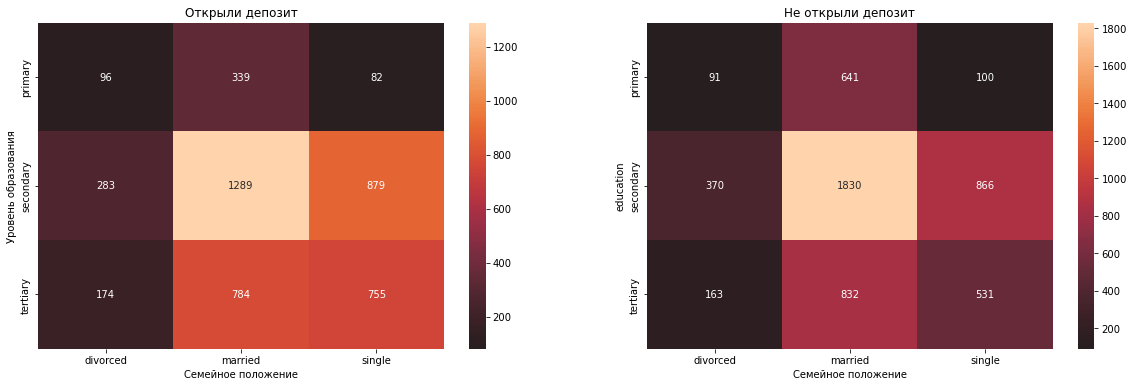

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

heatmap_positive = sns.heatmap(
    piv_table_positive, 
    fmt='.0f', 
    annot=True,
    center=0,
    ax=axes[0]
)

heatmap_positive.set_title('Открыли депозит')
heatmap_positive.set_xlabel('Семейное положение')
heatmap_positive.set_ylabel('Уровень образования')

heatmap_negative = sns.heatmap(
    piv_table_negative, 
    fmt='.0f', 
    annot=True,
    center=0,
    ax=axes[1]
)

heatmap_negative.set_title('Не открыли депозит')
heatmap_negative.set_xlabel('Семейное положение');

## Часть 3: преобразование данных

### Задание 1

In [25]:
# преобразуйте уровни образования
label_encoder = LabelEncoder()

df['education'] = label_encoder.fit_transform(df['education'])

df['education'].sum()

11995

In [26]:
df['age_range'] = label_encoder.fit_transform(df['age_range'])

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_range
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


### Задание 2

In [27]:
# преобразуйте бинарные переменные в представление из нулей и единиц
columns_to_bin = ['deposit', 'default', 'housing', 'loan']

for item in columns_to_bin:
    df[item] = df[item].apply(lambda x: 1 if x == 'yes' else 0)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_range
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [28]:
round(df['deposit'].std(), 3)

0.499

### Задание 3

In [29]:
# вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата 
# и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя
default_mean = df['default'].mean()
housing_mean = df['housing'].mean()
loan_mean = df['loan'].mean()

round(default_mean + housing_mean + loan_mean, 3)

0.635

### Задание 4

In [30]:
# сколько теперь всего признаков в датасете, не считая целевую переменную
df = pd.get_dummies(df)

df.shape

(10105, 46)

### Задание 5

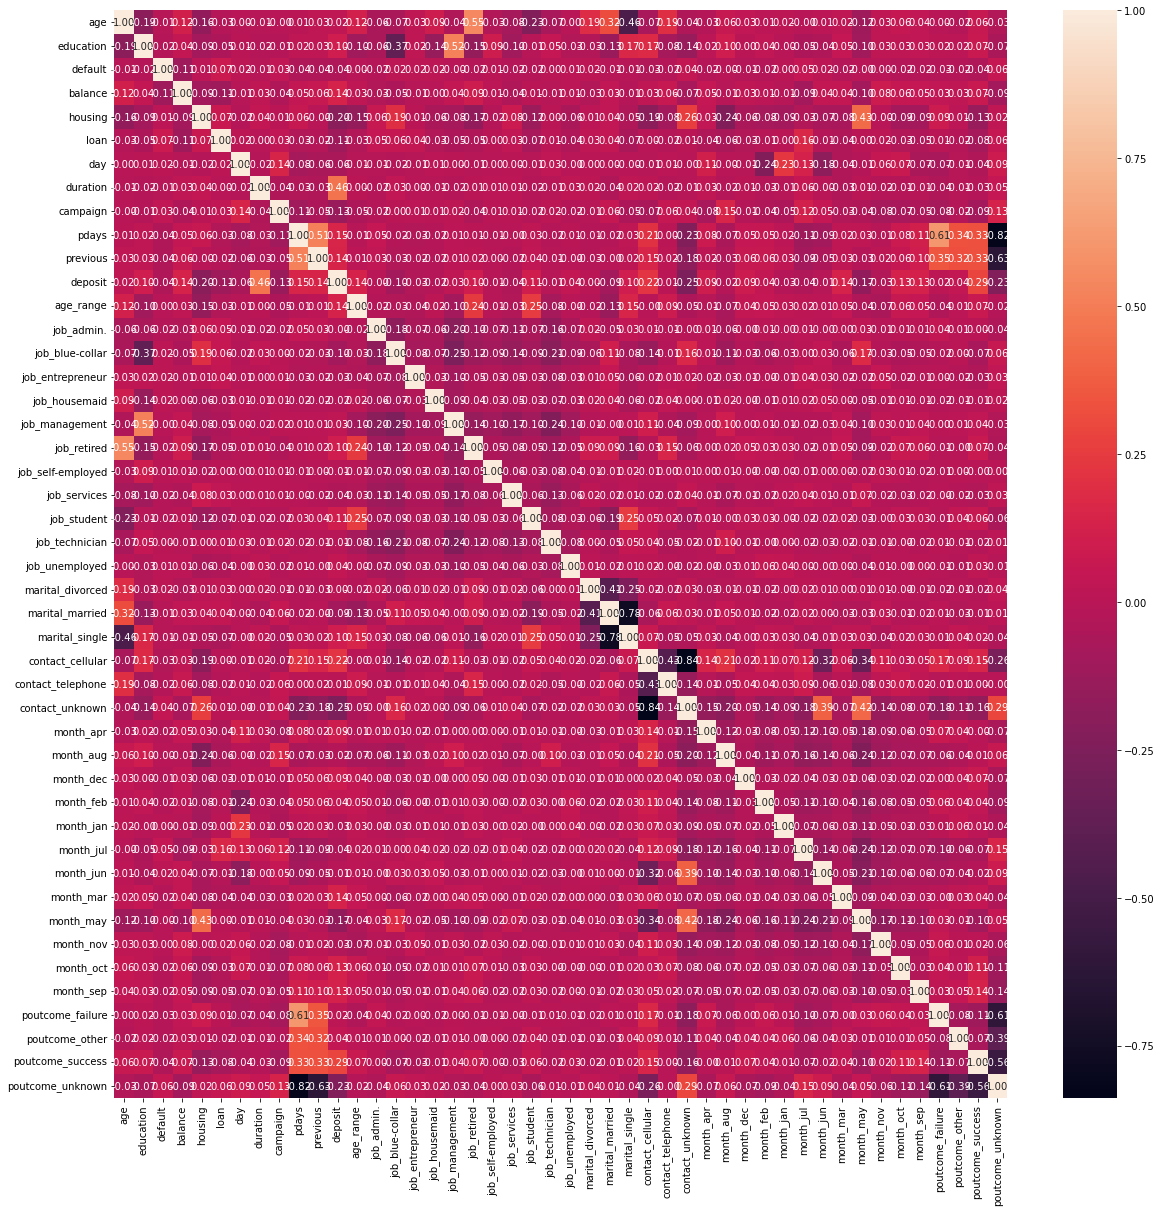

In [31]:
# теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной
plt.figure(figsize=(20,20))  

sns.heatmap(
    df.corr(),
    fmt='.2f',
    annot=True
);

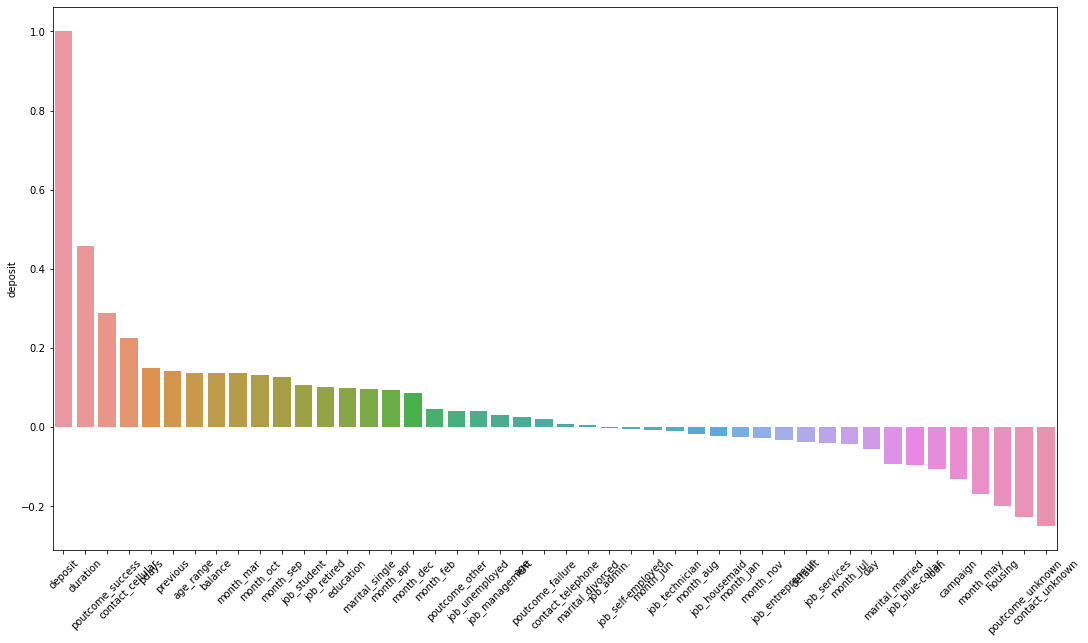

In [32]:
df_corr_sort = df.corr().sort_values('deposit', ascending=False)

plt.figure(figsize=(18,10)) 

barplot = sns.barplot(
    x=df_corr_sort.index,
    y=df_corr_sort['deposit']
)
barplot.set_xticklabels(barplot.get_xticklabels(),rotation = 45);

### Задание 7

In [33]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

print('Расмер обучающей выборки: ', X_train.shape)
print('Расмер тестовой выборки: ', X_test.shape)

Расмер обучающей выборки:  (6770, 45)
Расмер тестовой выборки:  (3335, 45)


### Задание 8

In [34]:
round(y_test.mean(), 2)

0.46

### Задание 9

In [35]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
skb = SelectKBest(score_func=f_classif, k=15)

skb.fit(X_train, y_train)

output_columns =list(skb.get_feature_names_out())

print(X_train.shape, X_test.shape)

X_train = pd.DataFrame(skb.transform(X_train), columns=output_columns)
X_test = pd.DataFrame(skb.transform(X_test), columns=output_columns)

(6770, 45) (3335, 45)


In [36]:
output_columns

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_range',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [37]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()

mm_scaler.fit(X_train)

X_train = pd.DataFrame(mm_scaler.transform(X_train), columns=output_columns)
X_test = pd.DataFrame(mm_scaler.transform(X_test), columns=output_columns)

In [38]:
round(X_train[output_columns[0]].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [39]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42)

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print('accuracy логистическая регрессия =', metrics.accuracy_score(y_test, y_pred_lr))

accuracy логистическая регрессия = 0.8047976011994002


### Задание 2

In [41]:
# обучите решающие деревья, настройте максимальную глубину
dt_cl = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

dt_cl.fit(X_train, y_train)

y_train_pred_dt = dt_cl.predict(X_train)
y_test_pred_dt = dt_cl.predict(X_test)

print('accuracy обучающая выборка =', metrics.accuracy_score(y_train, y_train_pred_dt))
print('accuracy тестовая выборка =', metrics.accuracy_score(y_test, y_test_pred_dt))
print(metrics.classification_report(y_test, y_test_pred_dt))

accuracy обучающая выборка = 1.0
accuracy тестовая выборка = 0.7472263868065967
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [42]:
accuracy_train = []
accuracy_test = []
max_depth = []

for item in range(1, 11):
    dt_cl_depth = tree.DecisionTreeClassifier(
        criterion='entropy', 
        max_depth=item,
        random_state=42
    )
    dt_cl_depth.fit(X_train, y_train)
    y_train_pred_dt_depth = dt_cl_depth.predict(X_train)
    y_test_pred_dt_depth = dt_cl_depth.predict(X_test)
    accuracy_train.append(metrics.accuracy_score(y_train, y_train_pred_dt_depth))
    accuracy_test.append(metrics.accuracy_score(y_test, y_test_pred_dt_depth))
    max_depth.append(item)

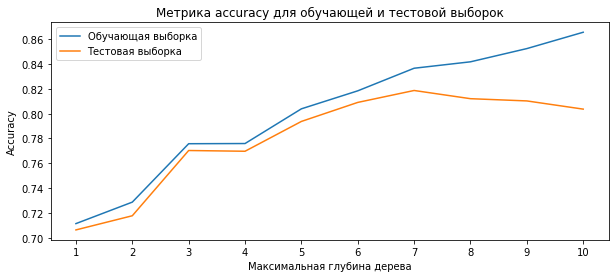

In [43]:
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

ax.plot(max_depth, accuracy_train, label='Обучающая выборка')
ax.plot(max_depth, accuracy_test, label='Тестовая выборка')

#Даем графику название и подписи осям
ax.set_title('Метрика accuracy для обучающей и тестовой выборок')
ax.set_xlabel('Максимальная глубина дерева')
ax.set_ylabel('Accuracy')
ax.set_xticks(max_depth)
ax.legend();

In [44]:
round(accuracy_test[5], 2)

0.81

### Задание 3

In [45]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy', 
        random_state=42
        ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
) 

grid_search.fit(X_train, y_train)

y_test_pred = grid_search.predict(X_test)

print('f1_score на тестовом наборе:', metrics.f1_score(y_test, y_test_pred))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на тестовом наборе: 0.805484693877551
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [50]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)

y_test_predict_rf = rf.predict(X_test)

print('recall тестовая выборка:', round(metrics.recall_score(y_test, y_test_predict_rf), 3))
print('accuracy тестовая выборка:', round(metrics.accuracy_score(y_test, y_test_predict_rf), 3))

recall тестовая выборка: 0.835
accuracy тестовая выборка: 0.828


### Задание 2

In [52]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

gb.fit(X_train, y_train)

y_test_predict_gb = gb.predict(X_test)

print('f1 тестовая выборка:', round(metrics.f1_score(y_test, y_test_predict_gb), 3))

f1 тестовая выборка: 0.817


In [53]:
print('RandomForest', metrics.classification_report(y_test, y_test_predict_rf))
print('GradientBoosting', metrics.classification_report(y_test, y_test_predict_gb))

RandomForest               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

GradientBoosting               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание4

In [59]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('log_reg', linear_model.LogisticRegression(solver='sag', random_state=42)),
    ('dt_cl', tree.DecisionTreeClassifier(criterion='entropy', random_state=42))
]

st_cl = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    )
)

st_cl.fit(X_train, y_train)

y_test_predict_st = st_cl.predict(X_test)

print('precision тестовая выборка:', round(metrics.precision_score(y_test, y_test_predict_st), 3))

precision тестовая выборка: 0.798


### Задание 4

In [63]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

### Задание 5

In [67]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
  
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [75]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=100)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2022-08-06 16:37:14,081] A new study created in memory with name: RandomForestClassifier
[I 2022-08-06 16:37:14,758] Trial 0 finished with value: 0.8567854909318324 and parameters: {'n_estimators': 121, 'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8567854909318324.
[I 2022-08-06 16:37:15,672] Trial 1 finished with value: 0.8765451416053825 and parameters: {'n_estimators': 153, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8765451416053825.
[I 2022-08-06 16:37:16,447] Trial 2 finished with value: 0.8562949078412996 and parameters: {'n_estimators': 151, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8765451416053825.
[I 2022-08-06 16:37:17,329] Trial 3 finished with value: 0.8922980588603631 and parameters: {'n_estimators': 155, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8922980588603631.
[I 2022-08-06 16:37:18,056] Trial 4 finished with value: 0.8905223647169221 and parameters: {'n_

[I 2022-08-06 16:37:43,419] Trial 38 finished with value: 0.8942758836409134 and parameters: {'n_estimators': 160, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.9251999372745805.
[I 2022-08-06 16:37:44,030] Trial 39 finished with value: 0.845234350424662 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 23 with value: 0.9251999372745805.
[I 2022-08-06 16:37:44,827] Trial 40 finished with value: 0.8690625000000001 and parameters: {'n_estimators': 143, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 23 with value: 0.9251999372745805.
[I 2022-08-06 16:37:45,539] Trial 41 finished with value: 0.9239454288850558 and parameters: {'n_estimators': 112, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.9251999372745805.
[I 2022-08-06 16:37:46,223] Trial 42 finished with value: 0.9241141423643776 and parameters: {'n_estimators': 107, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 23 with val

[I 2022-08-06 16:38:12,449] Trial 76 finished with value: 0.8929577464788733 and parameters: {'n_estimators': 103, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 65 with value: 0.9253684540608341.
[I 2022-08-06 16:38:13,228] Trial 77 finished with value: 0.8924714352793864 and parameters: {'n_estimators': 114, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 65 with value: 0.9253684540608341.
[I 2022-08-06 16:38:14,166] Trial 78 finished with value: 0.9244779400219815 and parameters: {'n_estimators': 141, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 65 with value: 0.9253684540608341.
[I 2022-08-06 16:38:15,036] Trial 79 finished with value: 0.9243776420854861 and parameters: {'n_estimators': 134, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 65 with value: 0.9253684540608341.
[I 2022-08-06 16:38:15,679] Trial 80 finished with value: 0.8775923904568844 and parameters: {'n_estimators': 109, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 65 with va

Наилучшие значения гиперпараметров {'n_estimators': 168, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93


In [76]:
model_optuna = ensemble.RandomForestClassifier(**study.best_params, random_state=42)

model_optuna.fit(X_train, y_train)

y_test_predict_rf_optuna = model_optuna.predict(X_test)
print('f1_score на тестовом наборе:', round(metrics.f1_score(y_test, y_test_predict_rf_optuna), 3))
print('accuracy тестовая выборка:', round(metrics.accuracy_score(y_test, y_test_predict_rf_optuna), 3))

f1_score на тестовом наборе: 0.815
accuracy тестовая выборка: 0.823
